In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

In [2]:
data = pd.read_csv("./flight_dataset.csv")
data.head()

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [3]:
data.shape

(10683, 14)

In [4]:
data.drop_duplicates(inplace=True)

In [5]:
data.shape

(10461, 14)

# Handling Outliers

In [6]:
data_copy = data.copy()

In [7]:
num_cols = data.select_dtypes(exclude='object').columns
for i in num_cols:
    data_copy['z_score'] = (data_copy[i] - data_copy[i].median())/data_copy[i].std()
    no_outier = data_copy[(data_copy['z_score'] > -3) & (data_copy['z_score'] < 3)]

In [8]:
no_outier.shape, data_copy.shape, data.shape

((10461, 15), (10461, 15), (10461, 14))

In [9]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numerical_columns = ['Price', 'Dep_hours', 'Dep_min', 'Arrival_hours', 'Arrival_min', 'Duration_hours', 'Duration_min']
for column in numerical_columns:
    df = remove_outliers_iqr(data, column)

In [10]:
df.shape

(10461, 14)

<Axes: >

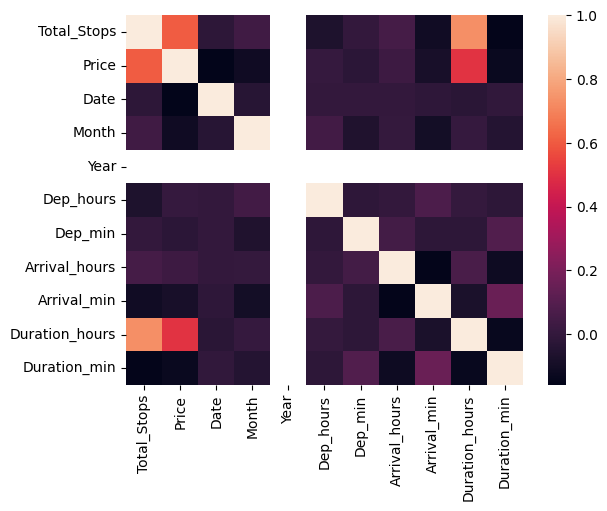

In [11]:
sns.heatmap(data.select_dtypes(exclude='object').corr())

# Normality Check and Transformation

In [12]:
shapiro(data['Price'])

c:\Users\muham\AppData\Local\anaconda3\envs\myenv_ver_3_12_4\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10461.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.8923776990752267), pvalue=np.float64(1.0172450472871817e-64))

In [13]:
def check_normally_distributed(df, col):
    stats, p = shapiro(df[col])
    
    if p < 0.05:
        if all(df[col] > 0):
            df[col] = np.log(df[col])
        elif all(df[col] >= 0):
            df[col] = np.sqrt(df[col])
        else:
            pt = PowerTransformer(method='box-cox')
            df[col] = pt.fit_transform(df[col])
    return df

In [14]:
for column in numerical_columns:
    df = check_normally_distributed(data, column)

In [15]:
X, y = df.drop(columns='Price'), df['Price']

In [16]:
categorical_columns = ['Airline', 'Source', 'Destination']
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

In [17]:
scaler = StandardScaler()

In [18]:
preprocessor = Pipeline(steps=[
    ('encoder', encoder), ('scaler', scaler)
])

In [19]:
X_preprocesssed = preprocessor.fit_transform(X=X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocesssed, y, test_size=0.2, random_state=42)

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],       # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],        # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30, 40, 50],         # Maximum number of levels in the tree
    'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                   # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]                       # Method of selecting samples for training each tree
}

In [22]:
model = RandomForestRegressor(
    n_estimators=200,  # Number of trees
    max_depth=20,      # Maximum depth of the tree
    min_samples_split=5,  # Minimum number of samples required to split an internal node
    min_samples_leaf=2,   # Minimum number of samples required to be at a leaf node
    random_state=42
)

In [24]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [25]:
y_pred = model.predict(X_test)

In [27]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}%")

RMSE: 0.18144163995715648
MAE: 0.12151039637273582
R²: 0.8756268578967764
MAPE: 1.352229207672237%
